In [1]:
import torch
import pennylane as qml
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib as plt
from model import QuantumCircuit, FullQuantumModel
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import os
from torch.utils.data import DataLoader, random_split

In [4]:
num_qubits = 8
num_layers = 3
model = FullQuantumModel(num_qubits, num_layers)

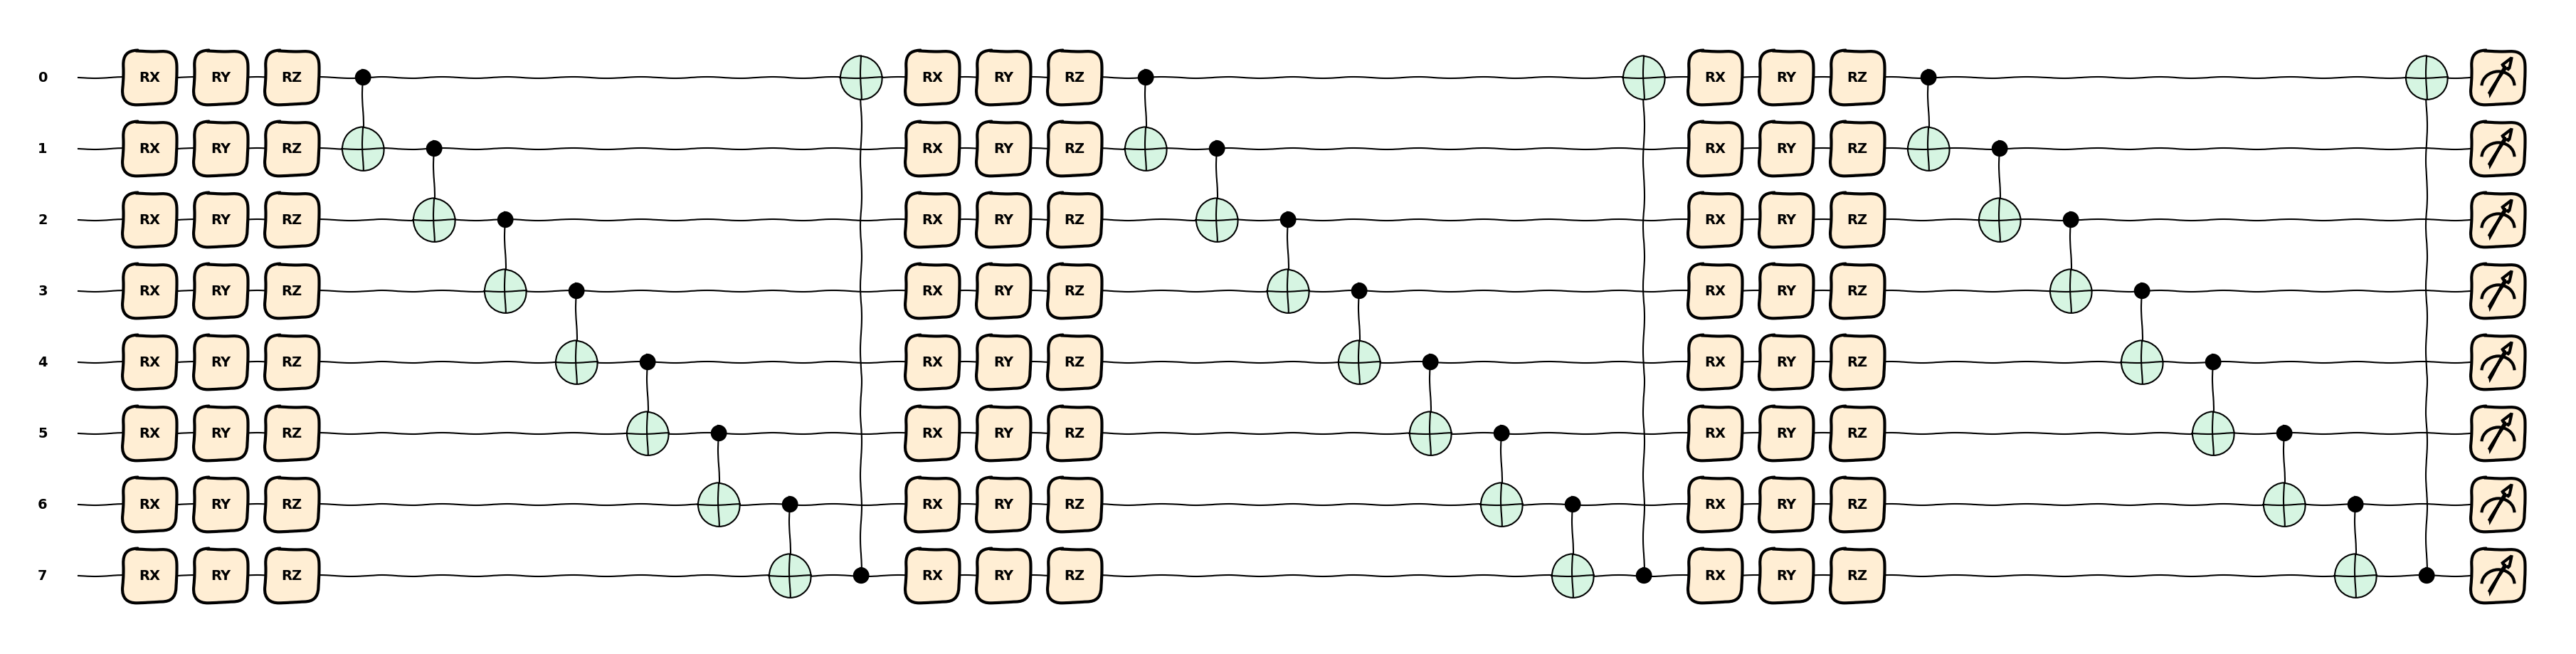

In [5]:
model.draw(style = 'sketch')

# Dataset preparation

In [6]:
# Download MNIST and prepare transforms
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
# Filter for zeros and ones
data = []
targets = []
for image, label in mnist_train:
    if label in [0, 1]:
        data.append(image.squeeze())
        targets.append(label)

data = torch.stack(data)
targets = torch.tensor(targets)
# Select 1024 zeros and 1024 ones for speed
zeros_indices = (targets == 0)
ones_indices = (targets == 1)

zeros = data[zeros_indices]
ones = data[ones_indices]

#normalize between 0 and 1
zeros_max = torch.max(zeros.reshape(-1, 16*16), dim = 1)
zeros_min = torch.min(zeros.reshape(-1, 16*16), dim = 1)
ones_max = torch.max(ones.reshape(-1, 16*16), dim = 1)
ones_min = torch.min(ones.reshape(-1, 16*16), dim = 1)

def normalize(imgs):
  maxes, _ = torch.max(imgs.reshape(-1, 16*16), dim = 1)
  mins, _ = torch.min(imgs.reshape(-1, 16*16), dim = 1)

  mins = mins.unsqueeze(1).unsqueeze(2)
  maxes = maxes.unsqueeze(1).unsqueeze(2)

  return (imgs-mins)/(maxes-mins)

zeros = normalize(zeros)
ones = normalize(ones)

# assert images have min 0 and max 1 within an error of 1e-5
assert torch.allclose(zeros.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

# concatenate the two datasets
zeros = zeros.flatten(start_dim = 1)
ones = ones.flatten(start_dim = 1)
dataset = torch.cat((zeros, ones), dim = 0)

# add labels
labels = torch.cat((torch.zeros((zeros.shape[0], 1)), torch.ones((ones.shape[0], 1))), dim = 0).squeeze()

# build dataloader
dataset = torch.utils.data.TensorDataset(dataset, labels)

In [7]:
#train/test split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [8]:
len(test_dataset)

2533

In [9]:
len(train_dataset)

10132

# Model training

In [ ]:
type(model.fit(dataloader=train_dataloader, learning_rate=0.01, epochs=1, show_plot=True))

Epoch 1/1:   0%|          | 0/316 [00:00<?, ?it/s]

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']